In [1]:
import numpy as np
import math
import time
import pickle
from scipy import optimize
import polyscope as ps
from barmesh.tribarmes import trianglebarmesh
from barmesh.basicgeo import P3
import barmesh.geodesicUtils as geo

In [2]:
fname = 'geometry/rotor1.stl'

tbm = trianglebarmesh.TriangleBarMesh(fname)


V = tbm.GetVertices()
F = tbm.GetFaces()
n = tbm.GetNormals()

Triangle bar mesh loaded with 12090 triangles of average size 4.46


In [3]:
geopaths=[]
curvs = []
faces =[]
barF,bGoRightF,lamF,barB,bGoRightB,lamB = [],[],[],[],[],[]
select = 0
thetas = ()
maxPathLength = 1000
badFaces = []
edgeBars = tbm.GetEdgeBars()
badEdgeBars = []
geolines =[]

def init_path(startFace):
    global geopaths
    global curvs
    global faces
    global barF,bGoRightF,lamF,barB,bGoRightB,lamB
    global thetas
    geopaths=[]
    curvs = []
    faces =[]
    barF,bGoRightF,lamF,barB,bGoRightB,lamB = [],[],[],[],[],[]
    x,y,z = 0,0,0
    for nn in tbm.faces[startFace].nodes:
        x += tbm.nodes[nn].p.x/3
        y += tbm.nodes[nn].p.y/3
        z += tbm.nodes[nn].p.z/3

    startPt = P3(x,y,z)#
    ref90 = P3(1,0,0)# A reference direction approximately perpendicular to the axis of the part
    ref0 = P3.Cross(ref90,tbm.faces[startFace].normal)
    thetas = np.arange(0,180,30)

    barsints =[]
    for theta in thetas:
        startVec = rotAxisAngle(ref0,tbm.faces[startFace].normal,theta)
        barsint =[]
        #find which bars intersect with the start vector
        for b in tbm.faces[startFace].bars:
            p1 = b.GetNodeFore(True).p
            vec1 = b.GetNodeFore(False).p-b.GetNodeFore(True).p
            try:
                Pint, lam = find_intersection(p1,vec1,startPt,startVec,tol=1e-4)
            except:
                lam = -1
                print('Error finding instersection between starting lines and edge of face, try specifying ref90 in different plane')
            if 0 < lam < 1:
                barsint.append((b,1-lam))
        barsints.append(barsint)

    for barsint in barsints:
        barF.append(barsint[0][0])
        bGoRightF.append(barF[-1].faceleft == startFace)
        lamF.append(barsint[0][1])
        barB.append(barsint[1][0])
        bGoRightB.append(barB[-1].faceleft == startFace)
        lamB.append(barsint[1][1])
        geopaths.append([startPt])
        curvs.append([0])
        faces.append([startFace])
        

def draw_paths():
    global geolines
    global select
    global badEdgeBars
    thetas = np.arange(0,180,10)
    if ps.get_selection()[1] != select:
        select = ps.get_selection()[1]
        if len(V) < select < (len(V)+len(F)):
            fselect = select - len(V)
            print('face',fselect)
        else:
            return
    else:
        return
    x,y,z = 0,0,0
    for nn in tbm.faces[fselect].nodes:
        x += tbm.nodes[nn].p.x/3
        y += tbm.nodes[nn].p.y/3
        z += tbm.nodes[nn].p.z/3

    startPt = P3(x,y,z)
    ref90 = P3(1,0,0)
    geolines =[]
    for th in thetas:
        print('calculating',th)
        geolineDouble = geo.createDoubleGeoLine(tbm, startPt, fselect, th, ref90,calc_thick = False, maxPathLength=1000)
        geolines.append(geolineDouble)
                
    for i in range(len(geolines)):
        if len(geolines[i]['pts'])>0:
            ps_geopath = ps.register_curve_network(str(thetas[i])+'deg', geo.P3list2array(geolines[i]['pts']), 'line')
            if len(geolines[i]['curvs']) == len(geolines[i]['pts']):
                ps_geopath.add_scalar_quantity("curvature", np.array(geolines[i]['curvs']), defined_on='nodes', enabled=True,  cmap='coolwarm',vminmax=(-0.005, 0.005))  
                

def increment_path():
    global geopaths
    global curvs
    global faces
    global barF,bGoRightF,lamF,barB,bGoRightB,lamB
    global select
    global thetas
    if ps.get_selection()[1] != select:
        select = ps.get_selection()[1]
        if len(V) < select < (len(V)+len(F)):
            fselect = select - len(V)
            print('face',fselect)
            init_path(fselect)
        
    allfinished = True
    for i in range(len(thetas)):
        if barF[i]==None and barB[i] ==None:
            f=True
        else:
            f =False
        allfinished = allfinished and f
    
    for i in range(len(thetas)):
        if allfinished: break
        if barF[i] != None:
            if bGoRightF[i]:
                faces[i].append(barF[i].faceright)
            else:
                faces[i].append(barF[i].faceleft)
            #print('face: ',faces[-1])
            c, barF[i], lamF[i], bGoRightF[i] = geo.GeoCrossBar(geopaths[i][-1], barF[i], lamF[i], bGoRightF[i])
            geopaths[i].append(c)
            if faces[i][-1] != None:
                CClast = geopaths[i][-1]-geopaths[i][-2]
                curvature = geo.P3.Dot(tbm.faces[faces[i][-1]].normal,CClast)/P3.Len(tbm.faces[faces[i][-1]].normal)
                curvs[i].append(curvs[i][-1]*0.75 + curvature*0.25)
            elif faces[i][-1] == None:
                curvs[i].append(curvs[i][-1])

        if barB[i] != None:
            if bGoRightB[i]:
                faces[i].insert(0,barB[i].faceright)
            else:
                faces[i].insert(0,barB[i].faceleft)
            #print('face: ',faces[-1])
            c, barB[i], lamB[i], bGoRightB[i] = geo.GeoCrossBar(geopaths[i][0], barB[i], lamB[i], bGoRightB[i])
            geopaths[i].insert(0,c)
            if faces[i][0] != None:
                CClast = geopaths[i][0]-geopaths[i][1]
                curvature = geo.P3.Dot(tbm.faces[faces[i][0]].normal,CClast)/P3.Len(tbm.faces[faces[i][0]].normal)
                curvs[i].insert(0,curvs[i][0]*0.75 + curvature*0.25)
            elif faces[i][0] == None:
                curvs[i].insert(0,curvs[i][0])
    for i in range(len(geopaths)):
        if allfinished: break
        ps_geopath = ps.register_curve_network(str(thetas[i])+'deg', P3list2array(geopaths[i]), 'line')
        if len(curvs[i]) == len(geopaths[i]):
            ps_geopath.add_scalar_quantity("curvature", -np.array(curvs[i]), defined_on='nodes', enabled=True,  cmap='coolwarm',vminmax=(-0.005, 0.005))

        
def selectBadFaces():
    global badFaces
    global select
    global edgeBars
    global badEdgeBars
    edgePts = []
    if ps.get_selection()[1] != select:
        select = ps.get_selection()[1]
        if len(V) < select < (len(V)+len(F)):
            fselect = select - len(V)
            print('face',fselect)
            badFaces.append(fselect)
            for b in tbm.faces[fselect].bars:
                for eb in edgeBars:
                    if b == eb:
                        badEdgeBars.append(eb)
                        eb.badedge = True
            eb1 = badEdgeBars[-1]
            goodEdgeBars = edgeBars
            for i in range(len(goodEdgeBars)):
                for eb2 in goodEdgeBars:
                    if (eb1.GetNodeFore(True) == eb2.GetNodeFore(True) or eb1.GetNodeFore(True) == eb2.GetNodeFore(False) or
                        eb1.GetNodeFore(False) == eb2.GetNodeFore(True) or eb1.GetNodeFore(False) == eb2.GetNodeFore(False)):
                        #print('match found at',eb2.i)
                        badEdgeBars.append(eb2)
                        eb2.badedge = True
                        goodEdgeBars.remove(eb2)
                        edgePts.append(eb2.GetNodeFore(True).p)
                        eb1 = eb2
                        break
            for b in badEdgeBars:
                if b.faceleft:
                    badFaces.append(b.faceleft)
                if b.faceright:
                    badFaces.append(b.faceright)
            col =[]
            B=(0.1,0.1,1)
            R=(1,0.1,0.1)
            badFaces = list(set(badFaces))
            for f in tbm.faces:
                bad = False
                for bf in badFaces:
                    if bf == f.i:
                        col.append(R)
                        bad = True
                if not bad:
                    col.append(B)
            #ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
            ps_surf.add_color_quantity("bad faces", np.array(col), defined_on='faces',enabled = True)
            if edgePts:
                ps_edgePts = ps.register_point_cloud('edgePts', geo.P3list2array(edgePts))
            
            

    else:
        return

In [4]:
#CLICK A FACE ADJENCENT TO AN EDGE TO BE AVOIDED

ps.init()

ps_surf = ps.register_surface_mesh("my mesh", V, F, edge_width = 1, smooth_shade=False)

ps.set_user_callback(selectBadFaces)
ps.show()
ps.clear_user_callback()
goodEdgeBars = geo.findGoodEdge(edgeBars,badEdgeBars)
goodEdgeBars = geo.sortBars(tbm, goodEdgeBars)

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 470.161.03
face 31


In [5]:
startFace = 6198
x,y,z = 0,0,0
for n in tbm.faces[startFace].nodes:
    x += n.p.x/3
    y += n.p.y/3
    z += n.p.z/3
startPt = P3(x,y,z)

theta = 45
ref0 = P3(0,1,0)
geoline = geo.createGeoLine(tbm, startPt, startFace, theta, ref0, calc_thick = False, maxPathLength = 10000)
print(geoline['length'])

PATH FAIL: max path length reached on path 45
10001.76826260614


In [6]:
def createTape(tbm, geoline, tw= 6.35,t=0.125,flip=False, a = 0):
    norm = tbm.faces[geoline['faces'][0]].normal
    v = geoline['pts'][1]-geoline['pts'][0]
    perp = P3.ZNorm(P3.Cross(v, norm))
    verts = [geoline['pts'][0]+ perp*(tw/2)+norm*t,geoline['pts'][0]- perp*(tw/2)+norm*t]
    faces = []
    for i in range(1,len(geoline['pts'])):
        if geoline['faces'][i]:
            norm = tbm.faces[geoline['faces'][i]].normal
            v = geoline['pts'][i]-geoline['pts'][i-1]
            perp = P3.ZNorm(P3.Cross(v, norm))
            if flip:
                verts += [geoline['pts'][i]+ perp*(tw/2)+norm*(2*t),geoline['pts'][i]- perp*(tw/2)+norm*(2*t)]
                faces +=[(len(verts)-3+a,len(verts)-2+a,len(verts)-1+a),(len(verts)-4+a,len(verts)-2+a,len(verts)-3+a)]
            else:
                verts += [geoline['pts'][i]+ perp*(tw/2)+norm*t,geoline['pts'][i]- perp*(tw/2)+norm*t]
                faces +=[(len(verts)-1+a,len(verts)-2+a,len(verts)-3+a),(len(verts)-3+a,len(verts)-2+a,len(verts)-4+a)]
    return np.array(verts), np.array(faces)

In [7]:
vs, fs = createTape(tbm, geoline, tw= 6.35,t=0.125,flip=False, a = 0)

In [8]:
ps.init()

ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
ps_geoline = ps.register_curve_network('geoline', geo.P3list2array(geoline['pts']), 'line')
ps_geolinepts = ps.register_point_cloud('geolinepts', geo.P3list2array(geoline['pts']))
#ps_geoline.add_scalar_quantity("curvature", np.array(curvs), defined_on='edges', enabled=True,  cmap='coolwarm')#,vminmax=(-1e-2, 1e-2))
ps_geoline.add_scalar_quantity("curvature", np.array(geoline['curvs']), enabled=True,  cmap='coolwarm')#,vminmax=(-1e-2, 1e-2))
ps_geolinepts.add_vector_quantity('edges', geo.P3list2array(geoline['edges']))
ps_tape = ps.register_surface_mesh("tape", vs, fs, smooth_shade=True, color = (0.2,0.2,0.2))
#rps_geolinepts = ps.register_point_cloud('rgeolinepts', geo.P3list2array(geolinerev['pts']))
#rps_geolinepts.add_scalar_quantity("curvature", np.array(rcurvs), enabled=True,  cmap='coolwarm')
ps.show()

In [23]:
startFace = 6198
x,y,z = 0,0,0
for n in tbm.faces[startFace].nodes:
    x += n.p.x/3
    y += n.p.y/3
    z += n.p.z/3
startPt = P3(x,y,z)
lim = (np.Inf,y,np.Inf)

theta = 45
ref0 = P3(0,-1,0)
geoline = geo.createGeoLine(tbm, startPt, startFace, theta, ref0,
                            calc_thick = False, maxPathLength = 10000, lim=lim)
print(geoline['length'])

266.8491353445421


In [27]:

geolinem = geo.createGeoLine(tbm, startPt, startFace, theta, ref0,
                            calc_thick = False, maxPathLength = 10000, lim=lim)
mirrorline = {'pts':list(geoline['pts']), 'edges':list(geoline['edges'])}
for i in range(len(geolinem['pts'])):
    pt = geolinem['pts'][i]
    mpt = P3(pt.x,-pt.y,pt.z)
    mirrorline['pts'].append(mpt)
    e = geolinem['edges'][i]
    mirrorline['edges'].append(-e)
    

In [10]:
Q = np.identity(3)
ply = {'pts':[mirrorline['pts'][0]],'edges':[mirrorline['edges'][0]]}
for i in range(20):
    for j in range(1,len(mirrorline['pts'])):
        v = mirrorline['pts'][j] - mirrorline['pts'][j-1]
        v = np.dot(Q,np.array((v.x,v.y,v.z)))
        v = P3(v[0],v[1],v[2])
        ply['pts'].append(ply['pts'][-1] + v)
        e = mirrorline['edges'][j]
        e = np.dot(Q,np.array((e.x,e.y,e.z)))
        e = P3(e[0],e[1],e[2])
        ply['edges'].append(e)
    Q = geo.find_rot(mirrorline['pts'][0], ply['pts'][-1])
    

In [29]:
ps.init()

ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
ps_geoline = ps.register_curve_network('geoline', geo.P3list2array(geoline['pts']), 'line')
ps_mirrorlinepts = ps.register_point_cloud('mirrorlinepts', geo.P3list2array(mirrorline['pts']))
ps_mirrorlinepts.add_vector_quantity('edges', geo.P3list2array(mirrorline['edges']))
#ps_geoline.add_scalar_quantity("curvature", #np.array(curvs), defined_on='nodes', enabled=True,  cmap='coolwarm')#,vminmax=(-1e-2, 1e-2))
ps_geolinepts.add_scalar_quantity("curvature", np.array(geoline['curvs']), enabled=True,  cmap='coolwarm')#,vminmax=(-1e-2, 1e-2))

#ps_ply = ps.register_curve_network('ply', geo.P3list2array(ply['pts']), 'line')
#ps_plypts = ps.register_point_cloud('ply', geo.P3list2array(ply['pts']))
#ps_plypts.add_vector_quantity('v', geo.P3list2array(ply['edges']), enabled = True)
#ps_seeds = ps.register_point_cloud('seeds',geo.P3list2array(seeds['pts']))
#ps_mgeoline.add_scalar_quantity("curvature", np.array(curvs), defined_on='edges', enabled=True,  cmap='coolwarm',vminmax=(-1e-2, 1e-2))

ps.show()

In [12]:
with open('geometry/PPR-fine/path-sharp corners.pkl', 'wb') as file_out:
    pickle.dump(ply,file_out,-1)

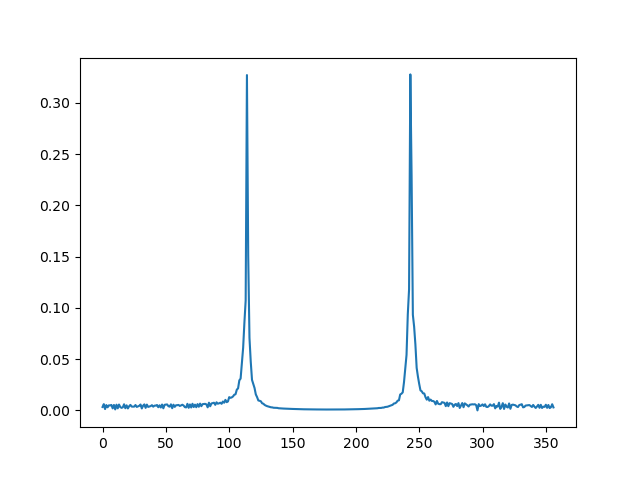

In [9]:
from matplotlib import pyplot as plt
%matplotlib widget

fig = plt.figure()
plt.plot(geoline['curvs'])
#plt.plot(curvs)
plt.show()

In [6]:
def findMinWind(seeds,incr=10, tol = 0.1):
    for i in range(len(seeds['pts'])):
        inc = incr
        valid_last = False
        theta = 0
        while inc > tol:
            #print('testing angle',theta)
            startPt = seeds['pts'][i]
            ref0 = seeds['ref0s'][i]
            startFace =seeds['faces'][i]
            geoline = geo.createGeoLine(tbm, startPt, startFace, theta, ref0, calc_thick = False, maxPathLength = 1000)
            theta_last = theta
            if geoline['valid'] != valid_last:
                inc /= 2
            valid_last = geoline['valid']
            if geoline['valid']:
                #print('geoline valid')
                theta -= inc
            else:
                #print('geoline invalid')
                theta += inc
        print('Min angle for seed',i,':', theta_last)
        seeds['thetas'][i] = theta_last    
    
    
findMinWind(seeds)

edge reached on path 0 deg
PATH FAIL: bad edge reached
edge reached on path 10 deg
PATH FAIL: bad edge reached
edge reached on path 20 deg
PATH FAIL: bad edge reached
edge reached on path 30 deg
edge reached on path 25.0 deg
edge reached on path 20.0 deg
PATH FAIL: bad edge reached
edge reached on path 22.5 deg
edge reached on path 21.25 deg
PATH FAIL: bad edge reached
edge reached on path 21.875 deg
PATH FAIL: bad edge reached
edge reached on path 22.5 deg
edge reached on path 22.1875 deg
PATH FAIL: bad edge reached
edge reached on path 22.34375 deg
PATH FAIL: bad edge reached
edge reached on path 22.5 deg
Min angle for seed 0 : 22.5
edge reached on path 0 deg
PATH FAIL: bad edge reached
edge reached on path 10 deg
PATH FAIL: bad edge reached
edge reached on path 20 deg
PATH FAIL: bad edge reached
edge reached on path 30 deg
edge reached on path 25.0 deg
edge reached on path 20.0 deg
PATH FAIL: bad edge reached
edge reached on path 22.5 deg
edge reached on path 21.25 deg
PATH FAIL: ba

In [7]:
geoplies = [geo.createPly(tbm,seeds)]
for i in range(22,80,2):
    ply = geo.createPly(tbm,seeds,i)
    if len(ply[0]) == len(seeds['pts']):
        print('ADDING PLY angle',i)
        geoplies.append(ply)

edge reached on path 22.5 deg
edge reached on path 22.1875 deg
edge reached on path 22.65625 deg
edge reached on path 22.5 deg
edge reached on path 22.1875 deg
edge reached on path 4.6875 deg
edge reached on path 22.5 deg
edge reached on path 22.1875 deg
edge reached on path 5.46875 deg
edge reached on path 22.5 deg
edge reached on path 22.1875 deg
edge reached on path 22.65625 deg
edge reached on path 22.5 deg
edge reached on path 22.1875 deg
edge reached on path 22.65625 deg
edge reached on path 22.5 deg
edge reached on path 16.875 deg
edge reached on path 22.65625 deg
edge reached on path 22.5 deg
edge reached on path 22.96875 deg
edge reached on path 22.65625 deg
edge reached on path 22.5 deg
edge reached on path 22.96875 deg
edge reached on path 22.65625 deg
edge reached on path 22.5 deg
edge reached on path 22.96875 deg
edge reached on path 20.9375 deg
edge reached on path 22.5 deg
edge reached on path 22.96875 deg
edge reached on path 22.65625 deg
edge reached on path 0.46875 de

In [9]:
with open('geometry/PPR-fine/geoplies.pkl', 'wb') as file_out:
    pickle.dump(geoplies,file_out,-1)

In [5]:
with open('geometry/PPR-fine/geoplies.pkl', 'rb') as input:
    geoplies=pickle.load(input)

In [6]:
geolines, thicks, ths = geo.createPly(tbm,seeds)
geolines2, thicks2,ths = geo.createPly(tbm,seeds,45)

NameError: name 'seeds' is not defined

In [7]:
Ttot= np.zeros(len(geoplies[0][1]))

weights = np.ones(len(geoplies))
#weights[5]=10
for i in range(0,len(geoplies)):
    Ttot += weights[i] * geoplies[i][1]

In [7]:
def error_func (weights, target):
    print('weights:', weights)
    Ttot = np.zeros(len(target))
    for i in range(0,len(geoplies)):
        Ttot += weights[i] * geoplies[i][1]
    ErrTot = 0
    for i in range(len(Ttot)):
        ErrTot += (Ttot[i]-target[i])**2
    return ErrTot

In [8]:
target = np.ones(len(geoplies[0][1]))*7
#error_func(weights,target)
weights = np.ones(len(geoplies))
res = optimize.minimize(error_func, x0 = weights, args = (target))
res

weights: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
weights: [1.00000001 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
weights: [1.         1.00000001 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
weights: [1.         1.         1.00000001 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
weights: [1.         1.        

      fun: 5727.395565845143
 hess_inv: array([[ 1.16707905e-03, -5.20437614e-04, -1.37484917e-04,
        -1.70597327e-04,  2.63697909e-05,  1.37781819e-05,
        -3.70378168e-05,  5.63612200e-05, -4.47827682e-04,
         4.25663588e-04, -5.32370802e-04,  2.90010510e-04,
        -1.75244256e-04,  5.15290070e-04, -5.26316328e-04,
        -3.68456529e-04,  5.45193102e-04,  6.66773707e-05,
        -2.01703816e-04, -2.16636684e-04, -4.43491351e-05,
         8.74834715e-05,  1.07501946e-04,  3.10735022e-04,
         5.15313554e-05, -1.73033323e-04,  3.62807175e-04,
        -3.72671793e-04],
       [-5.20437614e-04,  1.39130659e-03, -4.52939234e-04,
        -3.69776386e-05, -2.64988593e-04, -1.91307537e-04,
         2.27805696e-04, -8.07292861e-05,  3.25687108e-04,
        -6.17584494e-04,  6.41158908e-04, -3.04211320e-05,
         1.74629803e-04, -1.28524478e-03,  1.23495022e-03,
         8.45046151e-05, -3.96745169e-05,  2.74693013e-06,
         1.60886365e-04,  1.56245012e-04, -8.0107

In [9]:
weights = res['x']#*0.9
error_func(weights,target)

weights: [3.43818585 2.01200374 1.38070499 1.31871388 1.28727993 1.15375081
 1.1058726  1.03336261 1.16856654 0.74823283 1.01966391 0.80883318
 0.84147439 0.5684843  0.92232182 0.83702842 0.58285554 0.36482845
 0.76175508 0.64254884 0.59168674 0.38330943 0.37088866 0.2782385
 0.20471005 0.72997586 0.95206137 1.11527312]


5727.395565845143

In [10]:
weights = res['x']
Ttot= np.zeros(len(geoplies[0][1]))
for i in range(0,len(geoplies)):
    Ttot += weights[i] * geoplies[i][1]

In [ ]:
ps.init()
geonodes = []
geonodes2 = []
L1 = 0
L2 = 10
geolines = geoplies[L1][0]
geolines2 = geoplies[L2][0]
for geoline in geolines:
    geonodes = geonodes + geoline['pts']
for geoline in geolines2:
    geonodes2 = geonodes2 + geoline['pts'] 

ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
#ps_surf.add_scalar_quantity("thickness", geoplies[L1][1]+geoplies[L2][1], defined_on='vertices',enabled = True,cmap='coolwarm')
ps_surf.add_scalar_quantity("thickness", Ttot, defined_on='vertices',enabled = True,cmap='coolwarm')
ps.register_curve_network('geolines', geo.P3list2array(geonodes), 'line')
ps.register_curve_network('geolines2', geo.P3list2array(geonodes2), 'line')
ps.show()

ps.clear_user_callback()

# SCRAP BELOW THIS POINT

In [25]:
geolinerev = {'pts':[],'faces':[None]}
for i in range(len(geoline['pts'])):
    geolinerev['pts'].insert(0,geoline['pts'][i])
    if geoline['faces'][i]:
        geolinerev['faces'].insert(0,geoline['faces'][i])
#geolinerev

In [26]:
curvs = [0]
for i in range(1,len(geoline['pts'])-1):
    vlast = geoline['pts'][i] - geoline['pts'][i-1]
    vnext = geoline['pts'][i+1] - geoline['pts'][i]
    curvature = P3.Dot(tbm.faces[geoline['faces'][i]].normal,vlast)/P3.Len(tbm.faces[geoline['faces'][i]].normal) # This takes account of the length of the last segment intrinsically, normalisation by face normal is just in case it isn't 1
    curvature = curvature*P3.Len(vnext)
    curvs.append(curvature)
curvs.append(0)


#if faces[-1] != None:
#    CClast = pts[-1]-pts[-2]
#    curvature = P3.Dot(tbm.faces[faces[-1]].normal,CClast)/P3.Len(tbm.faces[faces[-1]].normal)
#    curvs.append(curvature)
#elif faces[-1] == None:
#    curvs.append(curvs[-1])
#curvs

In [27]:
rcurvs = [0]
for i in range(1,len(geolinerev['pts'])-1):
    vlast = geolinerev['pts'][i] - geolinerev['pts'][i-1]
    vnext = geolinerev['pts'][i+1] - geolinerev['pts'][i]
    curvature = P3.Dot(tbm.faces[geolinerev['faces'][i]].normal,vlast)/P3.Len(tbm.faces[geolinerev['faces'][i]].normal) # This takes account of the length of the last segment intrinsically, normalisation by face normal is just in case it isn't 1
    curvature = curvature*P3.Len(vnext)
    rcurvs.append(curvature)
rcurvs.append(0)
#rcurvs

In [50]:
def smoother(vals,av):
    smoothVals = []
    for i in range(len(vals)):
        lo = max(0,i-av)
        hi = min(i+av+1,len(vals))
        smoothVals.append(np.mean(vals[lo:hi]))
    return smoothVals
smcurvs = smoother(curvs,10)

In [34]:
theta = 0
geolines=[]
ref0s =[]
ref90s = []
startPts =[]
startVecs =[]
t0 = time.time()
for i in range(len(seeds['pts'])):
    print(i)
    startFace =seeds['faces'][i]
    pts = []
    #for n in tbm.faces[startFace].nodes: pts.append(n.p)
    #startPt = P3.midpoint(pts)
    startPt = seeds['pts'][i]
    startPts.append(startPt)
    ref0 = P3(0,0,1)
    ref0s.append(ref0)
    geoline = createGeoLine(tbm,startPt, startFace, theta, ref0, calc_thick = False, tw = 6.35, maxPathLength = 1000, tol = 1e-4)
    geolines.append(geoline)
    startVecs.append(geoline['startVec'])
print('Time taken:',time.time()-t0, 's')

0
-1.5528849113247276 6.410534508071502
0.00099999999999984 5.832840368174685e-12
0.0016429047561494874 0.004125488619118224
edge reached on path 0 deg
PATH FAIL: bad edge reached
1
0.4643429946673163 1.3413178721200198
edge reached on path 0 deg
PATH FAIL: bad edge reached
2
-0.10451679764414072 2.7735446619754742
0.3277046353648958 0.0
0.8374301845850569 2.102865273927116
edge reached on path 0 deg
PATH FAIL: bad edge reached
3
0.98612970876855 0.03482963320863208
edge reached on path 0 deg
PATH FAIL: bad edge reached
4
0.4508892484751318 1.3750053014405688
edge reached on path 0 deg
PATH FAIL: bad edge reached
5
-0.11838857747119547 2.8083791539078695
0.31926140301799 0.0
0.8158535868404363 2.048685271002335
edge reached on path 0 deg
PATH FAIL: bad edge reached
6
0.97225808433184 0.06966254806080735
edge reached on path 0 deg
PATH FAIL: bad edge reached
7
0.437435230069481 1.4086978160794392
edge reached on path 0 deg
PATH FAIL: bad edge reached
8
-0.13225889933463464 2.84320657407

In [35]:
len(geolines)

58

In [36]:
ps.init()
geonodes = []
#geonodes2 = []
for geoline in geolines:
    geonodes = geonodes + geoline['pts']
#for geoline in geolines2:
#    geonodes2 = geonodes2 + geoline['pts'] 

ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
#ps_surf.add_scalar_quantity("thickness", thicks, defined_on='vertices',enabled = True,cmap='coolwarm')
ps_startline = ps.register_curve_network('startline', geo.P3list2array(startPts), 'line')

ps_geolines = ps.register_curve_network('geolines', geo.P3list2array(geonodes), 'line')
ps_startPts = ps.register_point_cloud('startPts', geo.P3list2array(startPts))
ps_SP = ps.register_point_cloud("seedpts", geo.P3list2array(seeds['pts']))
ps_startPts.add_vector_quantity("ref0", geo.P3list2array(ref0s))
ps_startPts.add_vector_quantity("startVec", geo.P3list2array(startVecs))
ps.show()

ps.clear_user_callback()

In [18]:
theta = 45
geolines2=[]
t0 = time.time()

for i in range(len(seeds['pts'])):
    startPt = seeds['pts'][i]
    ref90 = seeds['ref90s'][i]
    startFace =seeds['faces'][i]
    ref0 = P3.Cross(ref90,tbm.faces[startFace].normal)
    startVec = rotAxisAngle(ref0,tbm.faces[startFace].normal,theta)
    forward = seeds['bFor'][i]
    geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = False,tw = 6.35, forward = forward, maxPathLength = 1000)
    if len(geoline['pts']) < 3:
        geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = False, tw = 6.35, forward = not forward, maxPathLength = 1000)
    geolines2.append(geoline)
print('Time taken:',time.time()-t0, 's')

edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
Error finding instersection between starting lines and edge of face, try specifying ref90 in different plane
Error finding instersection between starting lines and edge of face, try specifying ref90 in different plane
Error finding instersection between starting lines and edge of face, try specifying ref90 in different plane


IndexError: list index out of range

In [15]:
CPT = 0.125
lineThickness = np.zeros(len(thickLine['pts']))
lineThickness23 = np.zeros(len(thickLine['pts']))
lineThickness45 = np.zeros(len(thickLine['pts']))  

for geoline in geolines:
    for i in range(len(geoline['nodes'])):
        if geoline['nodes'][i]:
            lineThickness23[i] += CPT

for geoline in geolines2:
    for i in range(len(geoline['nodes'])):
        if geoline['nodes'][i]:
            lineThickness45[i] += CPT
            
for i in range(len(lineThickness)):
    lineThickness[i] = lineThickness23[i] + lineThickness45[i]

#lineThickness

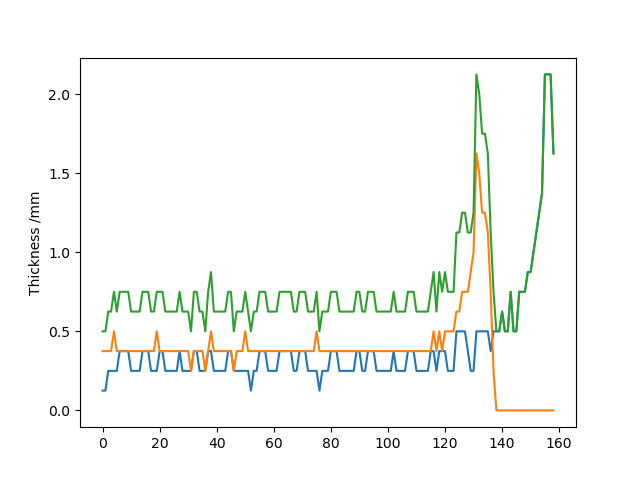

In [16]:
import matplotlib.pyplot as plt
%matplotlib widget
plt.figure()
plt.ylabel("Thickness /mm")
plt.plot(lineThickness23, label = '23')
plt.plot(lineThickness45, label = '45')
plt.plot(lineThickness, label = 'Total')
plt.show()

In [17]:
#theta = 23
geolines=[]
ref0s =[]
ref90s = []
startPts =[]
startVecs =[]
t0 = time.time()
for i in range(len(seeds['pts'])):
    theta = seeds['thetas'][i]
    startPt = seeds['pts'][i]
    startPts.append(startPt)
    ref90 = seeds['ref90s'][i]
    ref90s.append(ref90)
    startFace =seeds['faces'][i]
    ref0 = P3.Cross(ref90,tbm.faces[startFace].normal)
    ref0s.append(ref0)
    startVec = rotAxisAngle(ref0,tbm.faces[startFace].normal,theta)
    startVecs.append(startVec)
    forward = seeds['bFor'][i]
    geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = True, tw = 6.35, forward = forward, maxPathLength = 1000)
    if len(geoline['pts']) < 3:
        geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = True, tw = 6.35, forward = not forward, maxPathLength = 1000)
    geolines.append(geoline)
print('Time taken:',time.time()-t0, 's')

edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached

In [18]:
theta = 45
geolines2=[]
t0 = time.time()

for i in range(len(seeds['pts'])):
    startPt = seeds['pts'][i]
    ref90 = seeds['ref90s'][i]
    startFace =seeds['faces'][i]
    ref0 = P3.Cross(ref90,tbm.faces[startFace].normal)
    startVec = rotAxisAngle(ref0,tbm.faces[startFace].normal,theta)
    forward = seeds['bFor'][i]
    geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = True,tw = 6.35, forward = forward, maxPathLength = 1000)
    if len(geoline['pts']) < 3:
        geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = True, tw = 6.35, forward = not forward, maxPathLength = 1000)
    geolines2.append(geoline)
print('Time taken:',time.time()-t0, 's')

edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on 

In [19]:
CPT = 0.125
thicks = np.zeros(len(tbm.nodes))

for geoline in geolines:
    for n in geoline['nodes']:
        thicks[n.i] += CPT
        
for geoline in geolines2:
    for n in geoline['nodes']:
        thicks[n.i] += CPT

thicks

array([0.75 , 0.75 , 0.625, ..., 0.625, 0.625, 0.625])

In [21]:
ps.init()
#for i in range(len(tbm.bars)):
#    pt1 = tbm.bars[i].GetNodeFore(True).p
#    pt2 = tbm.bars[i].GetNodeFore(False).p
#    nodes = np.array([(pt1.x,pt1.y,pt1.z),(pt2.x,pt2.y,pt2.z)])
#    ps_net = ps.register_curve_network('bar'+str(i), nodes, 'line',radius = 0.002, enabled=False)
ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
ps_cloud = ps.register_point_cloud("vertices", V)
#ps_SP = ps.register_point_cloud("Start", P3list2array([startPt]))
#ps_SP.add_vector_quantity("ref", np.array([ref90]))
#for i in range(len(geopaths)):
#    ps_geopath = ps.register_curve_network(str(i), P3list2array(geopaths[i]), 'line')
#    ps_geopath.add_scalar_quantity("curvature", np.array(curvs[i]), defined_on='edges', enabled=True,  cmap='coolwarm',vminmax=(-0.1, 0.1))
ps_surf.add_vector_quantity("normals", n, defined_on='faces', color=(1, 0.5, 0.5))
ps.show()

AttributeError: 'TriangleNode' object has no attribute 'shape'

In [7]:
ps.init()

ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False, color = (0,0.9,0))
#ps_SP = ps.register_point_cloud("Start", P3list2array([startPt]))
#ps_SP.add_vector_quantity("ref", np.array([ref90]))


#    ps_geopath.add_scalar_quantity("curvature", np.array(curvs[i]), defined_on='edges', enabled=True,  cmap='coolwarm',vminmax=(-0.1, 0.1))        

#ps.set_user_callback(increment_path)
ps.set_user_callback(draw_paths)



ps.show()

ps.clear_user_callback()

In [13]:
ps.init()

ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
ps_SP = ps.register_point_cloud("Start", P3list2array([startPt]))
ps_SP.add_vector_quantity("ref", np.array([ref90]))
for i in range(len(geopaths)):
    ps_geopath = ps.register_curve_network(str(i), P3list2array(geopaths[i]), 'line')
    ps_geopath.add_scalar_quantity("curvature", np.array(curvs[i]), defined_on='edges', enabled=True,  cmap='coolwarm',vminmax=(-0.1, 0.1))
ps.show()

NameError: name 'startPt' is not defined

In [13]:
#Draw a single geodesic line from a specified point at a specified angle and ref90 A reference direction approximately perpendicular to the axis of the part    
#calc_thick can be either False (to not calculate thickness), True (to check for all nodes with 1/2 tw of line) or a list of points to check to see if within 1/2 tw of line
def createGeoLine(startPt, startFace, theta, ref90, calc_thick = False, tw = 6.35, forward = True, maxPathLength = 1000):
    valid = True
    fail = 0
    ref0 = P3.Cross(ref90,tbm.faces[startFace].normal)
    startVec = rotAxisAngle(ref0,tbm.faces[startFace].normal,theta)
    
    #find which bar intersects with the start vector
    barsint = []
    for b in tbm.faces[startFace].bars:
        p1 = b.GetNodeFore(True).p
        vec1 = b.GetNodeFore(False).p-b.GetNodeFore(True).p
        try:
            Pint, lam = find_intersection(p1,vec1,startPt,startVec,tol=1e-4)
        except:
            lam = -1
            print('Error finding instersection between starting lines and edge of face, try specifying ref90 in different plane')
        if 0 < lam < 1:
            barsint.append((b,1-lam))
    bar = barsint[int(forward)][0]
    bGoRight = bar.faceleft == startFace
    lam = barsint[int(forward)][1]
    
    pts = [startPt]
    faces = [startFace]
    curvs = [0]
    finished = False
    bar_last = tbm.bars[0]
    nodes = [] # list of nodes that fall within half a tow's width of the geoline
    A = startPt
    if type(calc_thick) == list:
        nodes = [False] * len(thickPts)
    while not finished:
        if bar != None:
            if bGoRight:
                faces.append(bar.faceright)
            else:
                faces.append(bar.faceleft)
            bar_last = bar
            pt, bar, lam, bGoRight = GeoCrossBar(pts[-1], bar, lam, bGoRight)
            pts.append(pt)
            
            #Thickness calc
            if calc_thick and type(calc_thick) != list:
                B = pt
                check_bars = [bar_last]
                i=0
                while i < len(check_bars):
                    nei = []
                    df,c = distPointLine(A,B,check_bars[i].GetNodeFore(True).p)
                    if df < tw/2 and check_bars[i].GetNodeFore(True) not in nodes:
                        nodes.append(check_bars[i].GetNodeFore(True))
                    db,c = distPointLine(A,B,check_bars[i].GetNodeFore(False).p)
                    if db < tw/2 and check_bars[i].GetNodeFore(False) not in nodes:
                        nodes.append(check_bars[i].GetNodeFore(False))

                    if check_bars[i].GetForeRightBL(True) and df < tw/2:
                        nei.append(check_bars[i].GetForeRightBL(True))
                    if check_bars[i].GetForeRightBL(False) and db < tw/2:
                        nei.append(check_bars[i].GetForeRightBL(False))
                    for b in nei:
                        if b not in check_bars:
                            check_bars.append(b)
                    i += 1
                A = B
                
## Probably may as well junc this function to calculate thickness only at provided points as it seems to take even longer.
            if type(calc_thick) == list:
                B = pt
                for i in range(len(calc_thick)):
                    db,c = distPointLine(A,B,calc_thick[i])
                    if db < tw/2:
                        nodes[i] = True
                A = B
            
            if faces[-1] != None:
                CClast = pts[-1]-pts[-2]
                curvature = P3.Dot(tbm.faces[faces[-1]].normal,CClast)/P3.Len(tbm.faces[faces[-1]].normal)
                curvs.append(curvs[-1]*0.75 + curvature*0.25)
            elif faces[-1] == None:
                curvs.append(curvs[-1])
        
        if bar==None:
            finished =True
            print('edge reached on path', theta)
            for be in badEdgeBars:
                if bar_last == be:
                    print('PATH FAIL: bad edge reached')
                    valid = False
                    fail = 1
        elif len(pts)>maxPathLength:
            finished =True
            print('max path length reached on path', theta)
        #elif ## SOME FUNCTION TO DETERMINE IF CURVATURE HAS BEEN EXCEEDED AND SET FAIL TO 2
        else:
            finished =False
    return {'pts':pts,'curvs':curvs,'faces':faces, 'nodes':nodes, 'valid':valid, 'fail':fail}